In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

import plotly.io as pio
pio.renderers.default = 'iframe' 

In [2]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [3]:
from utils.DS import DS, train_test, pd2tensor, time2int, int2time
from utils.NN import Net_Line_regres, Net_Snake #, SnakeNet, One_layer
from utils.train import Train
from utils.test import Test
from utils.metric import Metric_hist, History_keeper
from utils.plot_bar import plot_ts_pred, plot_hist_loss

# Prapare data

In [4]:
# Import the 5 years of hourly energy consumption data previously cleaned, explored, feature-engineered and... 
# ..stored as hourly1418_energy_temp_PV.csv

sdge = pd.read_csv('hourly1418_energy_temp_PV.csv', index_col = 'Dates', parse_dates=['Dates', 'Date'])

In [5]:
sdge

,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW
Dates,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.000000,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.000,220992.227
2014-01-01 01:00:00,1986.000000,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.000,220992.227
2014-01-01 02:00:00,1936.000000,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.000,220992.227
2014-01-01 03:00:00,1896.000000,2014-01-01,2014,1,1,3,Wednesday,winter,1,non-working,72290023188,0.0,7.0,50.0,0.000,220992.227
2014-01-01 04:00:00,1899.000000,2014-01-01,2014,1,1,4,Wednesday,winter,1,non-working,72290023188,0.0,7.0,48.8,0.000,220992.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2609.685890,2018-12-31,2018,12,31,19,Monday,winter,0,working,72290023188,0.0,10.0,50.0,1098.046,1034385.178
2018-12-31 20:00:00,2504.283858,2018-12-31,2018,12,31,20,Monday,winter,0,working,72290023188,0.0,10.0,50.0,1098.046,1034385.178
2018-12-31 21:00:00,2389.460971,2018-12-31,2018,12,31,21,Monday,winter,0,working,72290023188,0.0,10.0,51.0,1098.046,1034385.178


In [6]:
# creating categorical columns for linear regression 
cat_cols = ['year', 'month', 'day', 'hour', 'weekday', 'season', 'holiday', 'non_working']

for col in cat_cols:
    sdge[col] = sdge[col].astype('category')
sdge

,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW
Dates,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.000000,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.000,220992.227
2014-01-01 01:00:00,1986.000000,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.000,220992.227
2014-01-01 02:00:00,1936.000000,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.000,220992.227
2014-01-01 03:00:00,1896.000000,2014-01-01,2014,1,1,3,Wednesday,winter,1,non-working,72290023188,0.0,7.0,50.0,0.000,220992.227
2014-01-01 04:00:00,1899.000000,2014-01-01,2014,1,1,4,Wednesday,winter,1,non-working,72290023188,0.0,7.0,48.8,0.000,220992.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2609.685890,2018-12-31,2018,12,31,19,Monday,winter,0,working,72290023188,0.0,10.0,50.0,1098.046,1034385.178
2018-12-31 20:00:00,2504.283858,2018-12-31,2018,12,31,20,Monday,winter,0,working,72290023188,0.0,10.0,50.0,1098.046,1034385.178
2018-12-31 21:00:00,2389.460971,2018-12-31,2018,12,31,21,Monday,winter,0,working,72290023188,0.0,10.0,51.0,1098.046,1034385.178


In [7]:
sdge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2014-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SDGE                      43824 non-null  float64       
 1   Date                      43824 non-null  datetime64[ns]
 2   year                      43824 non-null  category      
 3   month                     43824 non-null  category      
 4   day                       43824 non-null  category      
 5   hour                      43824 non-null  category      
 6   weekday                   43824 non-null  category      
 7   season                    43824 non-null  category      
 8   holiday                   43824 non-null  category      
 9   non_working               43824 non-null  category      
 10  STATION                   43824 non-null  int64         
 11  DailyCoolingDegreeDays    43824 non-null  flo

In [8]:
# Preparing dummy columns for use in sklearn's linear regression 
sdge_lin = pd.get_dummies(sdge, drop_first = True)
sdge_lin.head(3)

,SDGE,Date,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW,year_2015,year_2016,...,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_winter,holiday_1,non_working_working
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014-01-01,72290023188,0.0,7.0,51.0,0.0,220992.227,False,False,...,False,False,False,False,False,False,True,True,True,False
2014-01-01 01:00:00,1986.0,2014-01-01,72290023188,0.0,7.0,51.5,0.0,220992.227,False,False,...,False,False,False,False,False,False,True,True,True,False
2014-01-01 02:00:00,1936.0,2014-01-01,72290023188,0.0,7.0,51.8,0.0,220992.227,False,False,...,False,False,False,False,False,False,True,True,True,False


In [9]:
sdge_lin.columns

Index(['SDGE', 'Date', 'STATION', 'DailyCoolingDegreeDays',
       'DailyHeatingDegreeDays', 'HourlyDryBulbTemperature', 'AC_kW',
       'cum_AC_kW', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'week

In [10]:
# Keeping only the necessary columns; day columns were removed because there is 0 to none monthly seasonality in the data    
sdge_lin.drop(['Date','STATION', 'AC_kW', 'DailyCoolingDegreeDays','DailyHeatingDegreeDays',           
              'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
              'weekday_Tuesday', 'weekday_Wednesday', 'holiday_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
               'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
               'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
               'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
               'day_28', 'day_29', 'day_30', 'day_31'], axis = 1, inplace = True)

In [11]:
sdge_lin.columns

Index(['SDGE', 'HourlyDryBulbTemperature', 'cum_AC_kW', 'year_2015',
       'year_2016', 'year_2017', 'year_2018', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'season_winter', 'non_working_working'],
      dtype='object')

In [12]:
# Creating the train and test data
# A test_size og 0.15 gives us a training set of 4 years and 3 months and a test set of 9 months (the test set includes 
#...winter and summer seasons.

cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW'] # other columns are binary values
X_train, X_test, y_train, y_test = train_test(sdge_lin, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)

In [13]:
sdge_lin

,SDGE,HourlyDryBulbTemperature,cum_AC_kW,year_2015,year_2016,year_2017,year_2018,month_2,month_3,month_4,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,season_winter,non_working_working
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.000000,51.0,220992.227,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 01:00:00,1986.000000,51.5,220992.227,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 02:00:00,1936.000000,51.8,220992.227,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 03:00:00,1896.000000,50.0,220992.227,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 04:00:00,1899.000000,48.8,220992.227,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2609.685890,50.0,1034385.178,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,True
2018-12-31 20:00:00,2504.283858,50.0,1034385.178,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,True,True
2018-12-31 21:00:00,2389.460971,51.0,1034385.178,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,True


In [14]:
X_train.columns.tolist()

['HourlyDryBulbTemperature',
 'cum_AC_kW',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'season_winter',
 'non_working_working']

## Train

In [15]:
X_train_tensor=pd2tensor(X_train)
y_train_tensor=pd2tensor(y_train)
time_train=time2int(X_train.index.values)

X_test_tensor=pd2tensor(X_test)
y_test_tensor=pd2tensor(y_test)
time_test=time2int(X_test.index.values)

In [16]:
len(X_train_tensor)

37250

In [17]:
X_train_tensor

tensor([[-1.9990, -1.4746,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [-1.9316, -1.4746,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [-1.8911, -1.4746,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [-0.7857,  1.7537,  0.0000,  ...,  1.0000,  1.0000,  0.0000],
        [-0.7857,  1.7552,  0.0000,  ...,  0.0000,  1.0000,  1.0000],
        [-0.7857,  1.7552,  0.0000,  ...,  0.0000,  1.0000,  1.0000]])

In [18]:
min(y_test_tensor)

tensor(1486.2361)

In [19]:
import plotly.express as px
import pandas as pd


fig = px.line( x=y_train.index, y=y_train, title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [20]:
batch_size = 16
num_workers = 16

## Train dataloader
train_dataset = DS(X_train_tensor, y_train_tensor, time_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) #  num_workers=num_workers,


## Test dataloader
test_dataset = DS(X_test_tensor, y_test_tensor, time_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # num_workers=num_workers,

In [22]:
from tqdm import tqdm
import time


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
device = torch.device("cpu")    
    
print(f"device: {device}")


input_feature = 42
alpha=4
# model = Net_Line_regres(input_feature).to(device) 
model = Net_Snake(input_feature, alpha).to(device) 


epochs=50
lr=0.001

pth_save_test="./weights/best_linear_regr_test.pth"
pth_save_train="./weights/best_linear_regr_train.pth"


# Prapare train
criteria = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr )
optimizer = torch.optim.SGD(model.parameters(), lr=lr ) # ,momentum=0.5

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs+1, steps_per_epoch=len(train_dataloader))

train=Train(train_dataloader,
            device,
            optimizer,
            criteria,
            scheduler)

test=Test(  test_dataloader,
            device,
            criteria)

hist_keep=History_keeper()
lrs = []


for epoch in tqdm(range(epochs)):
    model, train_loss  = train.run(model,epoch)
    test_loss  = test.run(model,epoch)
    
    # logging
    hist_keep.add_train(train_loss, epoch)
    hist_keep.add_test(test_loss, epoch)
    
    # compare_models
    # print(f"test_hist_accuracy {hist_keep.test_hist_accuracy}")
    print(f"min test_hist_loss {min(hist_keep.test_hist_loss)}")

    if  test_loss<=min(hist_keep.test_hist_loss):
        torch.save(model.state_dict(), pth_save_test)
        print(f"Best models saved on epoch: {epoch}, test_loss: {test_loss}")
        
    if  train_loss<=min(hist_keep.train_hist_loss):
        torch.save(model.state_dict(), pth_save_train)
        print(f"Best models saved on epoch: {epoch}, train_loss: {train_loss}")
        
    lrs.append(optimizer.param_groups[0]["lr"])


device: cpu


  0%|                                                    | 0/50 [00:00<?, ?it/s]

Running during epoch: 0, iteration: 723 of 2328 loss: 327778.312555

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Running during epoch: 0, iteration: 1771 of 2328 loss: 240063.015625

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

  2%|▉                                           | 1/50 [00:00<00:28,  1.75it/s]

Running during epoch: 0, iteration: 2327 of 2328 loss: 228309.4062555
TRAIN RESULTS: Epoch: 0,loss: 721583.0323
Time difference -0.4401988983154297

TEST RESULTS: Epoch: 0,loss: 386087.2348
min test_hist_loss 386087.2348
Best models saved on epoch: 0, test_loss: 386087.2348
Best models saved on epoch: 0, train_loss: 721583.0323
Running during epoch: 1, iteration: 1981 of 2328 loss: 272618.5937555

  4%|█▊                                          | 2/50 [00:01<00:27,  1.76it/s]

Running during epoch: 1, iteration: 2327 of 2328 loss: 217180.2187555
TRAIN RESULTS: Epoch: 1,loss: 277946.7081
Time difference -0.013184070587158203

TEST RESULTS: Epoch: 1,loss: 314088.2971
min test_hist_loss 314088.2971
Best models saved on epoch: 1, test_loss: 314088.2971
Best models saved on epoch: 1, train_loss: 277946.7081
Running during epoch: 2, iteration: 2218 of 2328 loss: 310758.5625755

  6%|██▋                                         | 3/50 [00:01<00:26,  1.79it/s]

Running during epoch: 2, iteration: 2327 of 2328 loss: 164685.8593755
TRAIN RESULTS: Epoch: 2,loss: 241554.2345
Time difference 0.4215209484100342

TEST RESULTS: Epoch: 2,loss: 257742.42
min test_hist_loss 257742.42
Best models saved on epoch: 2, test_loss: 257742.42
Best models saved on epoch: 2, train_loss: 241554.2345
Running during epoch: 3, iteration: 2327 of 2328 loss: 102934.0625555
TRAIN RESULTS: Epoch: 3,loss: 231591.1893
Time difference -0.12414312362670898


  8%|███▌                                        | 4/50 [00:02<00:25,  1.81it/s]


TEST RESULTS: Epoch: 3,loss: 237439.5695
min test_hist_loss 237439.5695
Best models saved on epoch: 3, test_loss: 237439.5695
Best models saved on epoch: 3, train_loss: 231591.1893
Running during epoch: 4, iteration: 1887 of 2328 loss: 528838.3125555

 10%|████▍                                       | 5/50 [00:02<00:24,  1.83it/s]

Running during epoch: 4, iteration: 2327 of 2328 loss: 307259.1875255
TRAIN RESULTS: Epoch: 4,loss: 229582.1591
Time difference 0.33133912086486816

TEST RESULTS: Epoch: 4,loss: 231454.2688
min test_hist_loss 231454.2688
Best models saved on epoch: 4, test_loss: 231454.2688
Best models saved on epoch: 4, train_loss: 229582.1591
Running during epoch: 5, iteration: 2208 of 2328 loss: 321309.3437555

 12%|█████▎                                      | 6/50 [00:03<00:23,  1.84it/s]

Running during epoch: 5, iteration: 2327 of 2328 loss: 73558.42968755
TRAIN RESULTS: Epoch: 5,loss: 229195.2205
Time difference -0.20590901374816895

TEST RESULTS: Epoch: 5,loss: 231554.9043
min test_hist_loss 231454.2688
Best models saved on epoch: 5, train_loss: 229195.2205
Running during epoch: 6, iteration: 1590 of 2328 loss: 159466.8437575

 14%|██████▏                                     | 7/50 [00:03<00:23,  1.85it/s]

Running during epoch: 6, iteration: 2327 of 2328 loss: 90723.46875375
TRAIN RESULTS: Epoch: 6,loss: 229106.7952
Time difference 0.25658702850341797

TEST RESULTS: Epoch: 6,loss: 228242.9995
min test_hist_loss 228242.9995
Best models saved on epoch: 6, test_loss: 228242.9995
Best models saved on epoch: 6, train_loss: 229106.7952
Running during epoch: 7, iteration: 1906 of 2328 loss: 565833.3752555

 16%|███████                                     | 8/50 [00:04<00:22,  1.85it/s]

Running during epoch: 7, iteration: 2327 of 2328 loss: 293667.3125255
TRAIN RESULTS: Epoch: 7,loss: 229031.9828
Time difference -0.2779362201690674

TEST RESULTS: Epoch: 7,loss: 231592.8867
min test_hist_loss 228242.9995
Best models saved on epoch: 7, train_loss: 229031.9828
Running during epoch: 8, iteration: 2222 of 2328 loss: 231208.6562555

 18%|███████▉                                    | 9/50 [00:04<00:22,  1.85it/s]

Running during epoch: 8, iteration: 2327 of 2328 loss: 277295.1252555
TRAIN RESULTS: Epoch: 8,loss: 228913.7382
Time difference 0.1844789981842041

TEST RESULTS: Epoch: 8,loss: 231478.5177
min test_hist_loss 228242.9995
Best models saved on epoch: 8, train_loss: 228913.7382
Running during epoch: 9, iteration: 1582 of 2328 loss: 202489.2575755

 20%|████████▌                                  | 10/50 [00:05<00:21,  1.86it/s]

Running during epoch: 9, iteration: 2327 of 2328 loss: 286275.2537555
TRAIN RESULTS: Epoch: 9,loss: 229035.2345
Time difference -0.3575019836425781

TEST RESULTS: Epoch: 9,loss: 232420.5212
min test_hist_loss 228242.9995
Running during epoch: 10, iteration: 1909 of 2328 loss: 307879.2812555

 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.86it/s]

Running during epoch: 10, iteration: 2327 of 2328 loss: 237206.8758755
TRAIN RESULTS: Epoch: 10,loss: 228992.2474
Time difference 0.10726499557495117

TEST RESULTS: Epoch: 10,loss: 231262.0563
min test_hist_loss 228242.9995
Running during epoch: 11, iteration: 2251 of 2328 loss: 588252.7562555

 24%|██████████▎                                | 12/50 [00:06<00:20,  1.86it/s]

Running during epoch: 11, iteration: 2327 of 2328 loss: 349315.1562555
TRAIN RESULTS: Epoch: 11,loss: 229041.6418
Time difference -0.4276118278503418

TEST RESULTS: Epoch: 11,loss: 232222.3248
min test_hist_loss 228242.9995
Running during epoch: 12, iteration: 1629 of 2328 loss: 67026.93757555

 26%|███████████▏                               | 13/50 [00:07<00:19,  1.87it/s]

Running during epoch: 12, iteration: 2327 of 2328 loss: 165395.1875555
TRAIN RESULTS: Epoch: 12,loss: 228977.4844
Time difference 0.03912806510925293

TEST RESULTS: Epoch: 12,loss: 233090.6274
min test_hist_loss 228242.9995
Running during epoch: 13, iteration: 1961 of 2328 loss: 331091.0218755

 28%|████████████                               | 14/50 [00:07<00:19,  1.86it/s]

Running during epoch: 13, iteration: 2327 of 2328 loss: 139866.0781255
TRAIN RESULTS: Epoch: 13,loss: 229010.3048
Time difference -0.49485301971435547

TEST RESULTS: Epoch: 13,loss: 232590.7938
min test_hist_loss 228242.9995
Running during epoch: 14, iteration: 2249 of 2328 loss: 391660.6875555

 30%|████████████▉                              | 15/50 [00:08<00:18,  1.86it/s]

Running during epoch: 14, iteration: 2327 of 2328 loss: 293802.8437555
TRAIN RESULTS: Epoch: 14,loss: 229092.015
Time difference -0.032569169998168945

TEST RESULTS: Epoch: 14,loss: 234907.0208
min test_hist_loss 228242.9995
Running during epoch: 15, iteration: 1621 of 2328 loss: 124559.5512555

 32%|█████████████▊                             | 16/50 [00:08<00:18,  1.86it/s]

Running during epoch: 15, iteration: 2327 of 2328 loss: 299886.8125525
TRAIN RESULTS: Epoch: 15,loss: 228953.3948
Time difference 0.4236469268798828

TEST RESULTS: Epoch: 15,loss: 233187.5883
min test_hist_loss 228242.9995
Running during epoch: 16, iteration: 1942 of 2328 loss: 97886.14843755

 34%|██████████████▌                            | 17/50 [00:09<00:17,  1.86it/s]

Running during epoch: 16, iteration: 2327 of 2328 loss: 338034.1252575
TRAIN RESULTS: Epoch: 16,loss: 229050.2216
Time difference -0.11303591728210449

TEST RESULTS: Epoch: 16,loss: 232499.4591
min test_hist_loss 228242.9995
Running during epoch: 17, iteration: 2279 of 2328 loss: 174197.8437555

 36%|███████████████▍                           | 18/50 [00:09<00:17,  1.86it/s]

Running during epoch: 17, iteration: 2327 of 2328 loss: 186968.968755
TRAIN RESULTS: Epoch: 17,loss: 229049.9228
Time difference 0.35091495513916016

TEST RESULTS: Epoch: 17,loss: 231902.409
min test_hist_loss 228242.9995
Running during epoch: 18, iteration: 1634 of 2328 loss: 241517.6255755

 38%|████████████████▎                          | 19/50 [00:10<00:16,  1.86it/s]

Running during epoch: 18, iteration: 2327 of 2328 loss: 198927.0937555
TRAIN RESULTS: Epoch: 18,loss: 228974.0182
Time difference -0.18391084671020508

TEST RESULTS: Epoch: 18,loss: 230303.6087
min test_hist_loss 228242.9995
Running during epoch: 19, iteration: 1915 of 2328 loss: 276842.0625555

 40%|█████████████████▏                         | 20/50 [00:10<00:16,  1.85it/s]

Running during epoch: 19, iteration: 2327 of 2328 loss: 208632.7656255
TRAIN RESULTS: Epoch: 19,loss: 229095.4019
Time difference 0.2738780975341797

TEST RESULTS: Epoch: 19,loss: 230453.3275
min test_hist_loss 228242.9995
Running during epoch: 20, iteration: 2222 of 2328 loss: 314223.7187555

 42%|██████████████████                         | 21/50 [00:11<00:15,  1.85it/s]

Running during epoch: 20, iteration: 2327 of 2328 loss: 270962.7812555
TRAIN RESULTS: Epoch: 20,loss: 229066.1143
Time difference -0.26874804496765137

TEST RESULTS: Epoch: 20,loss: 234617.8384
min test_hist_loss 228242.9995
Running during epoch: 21, iteration: 1602 of 2328 loss: 246108.0156255

 44%|██████████████████▉                        | 22/50 [00:11<00:15,  1.86it/s]

Running during epoch: 21, iteration: 2327 of 2328 loss: 100975.9609375
TRAIN RESULTS: Epoch: 21,loss: 228933.3728
Time difference 0.1901559829711914

TEST RESULTS: Epoch: 21,loss: 231559.7164
min test_hist_loss 228242.9995
Running during epoch: 22, iteration: 1919 of 2328 loss: 269285.9062555

 46%|███████████████████▊                       | 23/50 [00:12<00:14,  1.86it/s]

Running during epoch: 22, iteration: 2327 of 2328 loss: 138083.8437555
TRAIN RESULTS: Epoch: 22,loss: 229011.219
Time difference -0.34331488609313965

TEST RESULTS: Epoch: 22,loss: 232738.3677
min test_hist_loss 228242.9995
Running during epoch: 23, iteration: 2228 of 2328 loss: 254794.0625555

 48%|████████████████████▋                      | 24/50 [00:12<00:14,  1.86it/s]

Running during epoch: 23, iteration: 2327 of 2328 loss: 194600.4687555
TRAIN RESULTS: Epoch: 23,loss: 228973.9863
Time difference 0.11660003662109375

TEST RESULTS: Epoch: 23,loss: 233299.6377
min test_hist_loss 228242.9995
Running during epoch: 24, iteration: 1593 of 2328 loss: 199878.0468755

 50%|█████████████████████▌                     | 25/50 [00:13<00:13,  1.86it/s]

Running during epoch: 24, iteration: 2327 of 2328 loss: 114281.2187555
TRAIN RESULTS: Epoch: 24,loss: 228993.6811
Time difference -0.42170286178588867

TEST RESULTS: Epoch: 24,loss: 230719.796
min test_hist_loss 228242.9995
Running during epoch: 25, iteration: 1911 of 2328 loss: 91620.26562555

 52%|██████████████████████▎                    | 26/50 [00:14<00:12,  1.86it/s]

Running during epoch: 25, iteration: 2327 of 2328 loss: 230284.8752555
TRAIN RESULTS: Epoch: 25,loss: 228936.1047
Time difference 0.041172027587890625

TEST RESULTS: Epoch: 25,loss: 231955.0373
min test_hist_loss 228242.9995
Running during epoch: 26, iteration: 2244 of 2328 loss: 305615.0718755

 54%|███████████████████████▏                   | 27/50 [00:14<00:12,  1.86it/s]

Running during epoch: 26, iteration: 2327 of 2328 loss: 140843.0781255
TRAIN RESULTS: Epoch: 26,loss: 228896.2459
Time difference -0.49755287170410156

TEST RESULTS: Epoch: 26,loss: 232366.5787
min test_hist_loss 228242.9995
Best models saved on epoch: 26, train_loss: 228896.2459
Running during epoch: 27, iteration: 1621 of 2328 loss: 138999.3125255

 56%|████████████████████████                   | 28/50 [00:15<00:11,  1.87it/s]

Running during epoch: 27, iteration: 2327 of 2328 loss: 434539.3755555
TRAIN RESULTS: Epoch: 27,loss: 228897.7132
Time difference -0.03241300582885742

TEST RESULTS: Epoch: 27,loss: 230796.2158
min test_hist_loss 228242.9995
Running during epoch: 28, iteration: 1964 of 2328 loss: 193231.0781255

 58%|████████████████████████▉                  | 29/50 [00:15<00:11,  1.87it/s]

Running during epoch: 28, iteration: 2327 of 2328 loss: 315780.0218755
TRAIN RESULTS: Epoch: 28,loss: 228990.0983
Time difference 0.43398404121398926

TEST RESULTS: Epoch: 28,loss: 229614.3296
min test_hist_loss 228242.9995
Running during epoch: 29, iteration: 2294 of 2328 loss: 157561.8281255

 60%|█████████████████████████▊                 | 30/50 [00:16<00:10,  1.87it/s]

Running during epoch: 29, iteration: 2327 of 2328 loss: 229779.0468755
TRAIN RESULTS: Epoch: 29,loss: 228986.4292
Time difference -0.1004478931427002

TEST RESULTS: Epoch: 29,loss: 231055.8265
min test_hist_loss 228242.9995
Running during epoch: 30, iteration: 1679 of 2328 loss: 168185.6255255

 62%|██████████████████████████▋                | 31/50 [00:16<00:10,  1.87it/s]

Running during epoch: 30, iteration: 2327 of 2328 loss: 300820.2187555
TRAIN RESULTS: Epoch: 30,loss: 228978.7084
Time difference 0.3642239570617676

TEST RESULTS: Epoch: 30,loss: 230465.9669
min test_hist_loss 228242.9995
Running during epoch: 31, iteration: 2007 of 2328 loss: 231842.2187555

 64%|███████████████████████████▌               | 32/50 [00:17<00:09,  1.87it/s]

Running during epoch: 31, iteration: 2327 of 2328 loss: 272254.8437555
TRAIN RESULTS: Epoch: 31,loss: 228955.2471
Time difference -0.16963410377502441

TEST RESULTS: Epoch: 31,loss: 231867.5663
min test_hist_loss 228242.9995
Running during epoch: 32, iteration: 2327 of 2328 loss: 245591.6253755
TRAIN RESULTS: Epoch: 32,loss: 228901.5149
Time difference 0.29465508460998535


 66%|████████████████████████████▍              | 33/50 [00:17<00:09,  1.87it/s]


TEST RESULTS: Epoch: 32,loss: 232923.2938
min test_hist_loss 228242.9995
Running during epoch: 33, iteration: 1885 of 2328 loss: 206978.2343755

 68%|█████████████████████████████▏             | 34/50 [00:18<00:08,  1.86it/s]

Running during epoch: 33, iteration: 2327 of 2328 loss: 134450.2812555
TRAIN RESULTS: Epoch: 33,loss: 228994.434
Time difference -0.2424178123474121

TEST RESULTS: Epoch: 33,loss: 230684.5153
min test_hist_loss 228242.9995
Running during epoch: 34, iteration: 2194 of 2328 loss: 272121.9062525

 70%|██████████████████████████████             | 35/50 [00:18<00:08,  1.86it/s]

Running during epoch: 34, iteration: 2327 of 2328 loss: 280891.8125125
TRAIN RESULTS: Epoch: 34,loss: 228948.346
Time difference 0.21979117393493652

TEST RESULTS: Epoch: 34,loss: 232881.777
min test_hist_loss 228242.9995
Running during epoch: 35, iteration: 1566 of 2328 loss: 217290.5468755

 72%|██████████████████████████████▉            | 36/50 [00:19<00:07,  1.86it/s]

Running during epoch: 35, iteration: 2327 of 2328 loss: 96137.92187555
TRAIN RESULTS: Epoch: 35,loss: 228988.8762
Time difference -0.320720911026001

TEST RESULTS: Epoch: 35,loss: 235517.7204
min test_hist_loss 228242.9995
Running during epoch: 36, iteration: 1883 of 2328 loss: 408072.7812555

 74%|███████████████████████████████▊           | 37/50 [00:19<00:06,  1.86it/s]

Running during epoch: 36, iteration: 2327 of 2328 loss: 298461.1875755
TRAIN RESULTS: Epoch: 36,loss: 228817.295
Time difference 0.14404606819152832

TEST RESULTS: Epoch: 36,loss: 233591.4268
min test_hist_loss 228242.9995
Best models saved on epoch: 36, train_loss: 228817.295
Running during epoch: 37, iteration: 2179 of 2328 loss: 99937.21875255

 76%|████████████████████████████████▋          | 38/50 [00:20<00:06,  1.85it/s]

Running during epoch: 37, iteration: 2327 of 2328 loss: 286341.9375555
TRAIN RESULTS: Epoch: 37,loss: 228855.437
Time difference -0.3939340114593506

TEST RESULTS: Epoch: 37,loss: 230931.8023
min test_hist_loss 228242.9995
Running during epoch: 38, iteration: 2327 of 2328 loss: 196737.8125755
TRAIN RESULTS: Epoch: 38,loss: 228772.9828
Time difference 0.06274104118347168


 78%|█████████████████████████████████▌         | 39/50 [00:21<00:05,  1.86it/s]


TEST RESULTS: Epoch: 38,loss: 226652.2873
min test_hist_loss 226652.2873
Best models saved on epoch: 38, test_loss: 226652.2873
Best models saved on epoch: 38, train_loss: 228772.9828
Running during epoch: 39, iteration: 1889 of 2328 loss: 155031.7812555

 80%|██████████████████████████████████▍        | 40/50 [00:21<00:05,  1.86it/s]

Running during epoch: 39, iteration: 2327 of 2328 loss: 257079.1875755
TRAIN RESULTS: Epoch: 39,loss: 228848.2563
Time difference -0.47377514839172363

TEST RESULTS: Epoch: 39,loss: 231143.7196
min test_hist_loss 226652.2873
Running during epoch: 40, iteration: 2220 of 2328 loss: 271627.9687555

 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.86it/s]

Running during epoch: 40, iteration: 2327 of 2328 loss: 205375.6875555
TRAIN RESULTS: Epoch: 40,loss: 228829.8553
Time difference -0.011008024215698242

TEST RESULTS: Epoch: 40,loss: 231565.4569
min test_hist_loss 226652.2873
Running during epoch: 41, iteration: 1588 of 2328 loss: 228811.2587555

 84%|████████████████████████████████████       | 42/50 [00:22<00:04,  1.86it/s]

Running during epoch: 41, iteration: 2327 of 2328 loss: 138314.8125555
TRAIN RESULTS: Epoch: 41,loss: 228814.4031
Time difference 0.4539070129394531

TEST RESULTS: Epoch: 41,loss: 231121.9348
min test_hist_loss 226652.2873
Running during epoch: 42, iteration: 1902 of 2328 loss: 256528.1093755

 86%|████████████████████████████████████▉      | 43/50 [00:23<00:03,  1.86it/s]

Running during epoch: 42, iteration: 2327 of 2328 loss: 182142.7540625
TRAIN RESULTS: Epoch: 42,loss: 228791.9174
Time difference -0.08127403259277344

TEST RESULTS: Epoch: 42,loss: 233681.9519
min test_hist_loss 226652.2873
Running during epoch: 43, iteration: 2203 of 2328 loss: 198179.9062555

 88%|█████████████████████████████████████▊     | 44/50 [00:23<00:03,  1.86it/s]

Running during epoch: 43, iteration: 2327 of 2328 loss: 162459.9062555
TRAIN RESULTS: Epoch: 43,loss: 228775.8003
Time difference 0.37865710258483887

TEST RESULTS: Epoch: 43,loss: 232864.3528
min test_hist_loss 226652.2873
Running during epoch: 44, iteration: 1571 of 2328 loss: 429954.4375555

 90%|██████████████████████████████████████▋    | 45/50 [00:24<00:02,  1.86it/s]

Running during epoch: 44, iteration: 2327 of 2328 loss: 161293.6718755
TRAIN RESULTS: Epoch: 44,loss: 228661.5042
Time difference -0.16317105293273926

TEST RESULTS: Epoch: 44,loss: 231237.5945
min test_hist_loss 226652.2873
Best models saved on epoch: 44, train_loss: 228661.5042
Running during epoch: 45, iteration: 1906 of 2328 loss: 214533.2031255

 92%|███████████████████████████████████████▌   | 46/50 [00:24<00:02,  1.86it/s]

Running during epoch: 45, iteration: 2327 of 2328 loss: 266676.0625255
TRAIN RESULTS: Epoch: 45,loss: 228717.3163
Time difference 0.300037145614624

TEST RESULTS: Epoch: 45,loss: 231439.1517
min test_hist_loss 226652.2873
Running during epoch: 46, iteration: 2215 of 2328 loss: 121764.5078125

 94%|████████████████████████████████████████▍  | 47/50 [00:25<00:01,  1.86it/s]

Running during epoch: 46, iteration: 2327 of 2328 loss: 76511.07031255
TRAIN RESULTS: Epoch: 46,loss: 228728.2352
Time difference -0.23477816581726074

TEST RESULTS: Epoch: 46,loss: 230987.8136
min test_hist_loss 226652.2873
Running during epoch: 47, iteration: 2327 of 2328 loss: 367628.3753755
TRAIN RESULTS: Epoch: 47,loss: 228768.9368
Time difference 0.224776029586792


 96%|█████████████████████████████████████████▎ | 48/50 [00:25<00:01,  1.85it/s]


TEST RESULTS: Epoch: 47,loss: 231713.4845
min test_hist_loss 226652.2873
Running during epoch: 48, iteration: 1880 of 2328 loss: 248299.7656255

 98%|██████████████████████████████████████████▏| 49/50 [00:26<00:00,  1.85it/s]

Running during epoch: 48, iteration: 2327 of 2328 loss: 139446.9843755
TRAIN RESULTS: Epoch: 48,loss: 228702.3406
Time difference -0.32231712341308594

TEST RESULTS: Epoch: 48,loss: 231654.4813
min test_hist_loss 226652.2873
Running during epoch: 49, iteration: 2186 of 2328 loss: 186621.1718755

100%|███████████████████████████████████████████| 50/50 [00:26<00:00,  1.85it/s]

Running during epoch: 49, iteration: 2327 of 2328 loss: 112907.1875755
TRAIN RESULTS: Epoch: 49,loss: 228695.7875
Time difference 0.13822197914123535

TEST RESULTS: Epoch: 49,loss: 231432.2503
min test_hist_loss 226652.2873


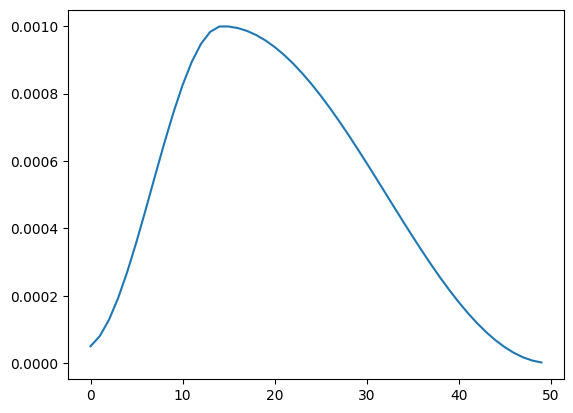

In [23]:
plt.plot(lrs)

226652.2873


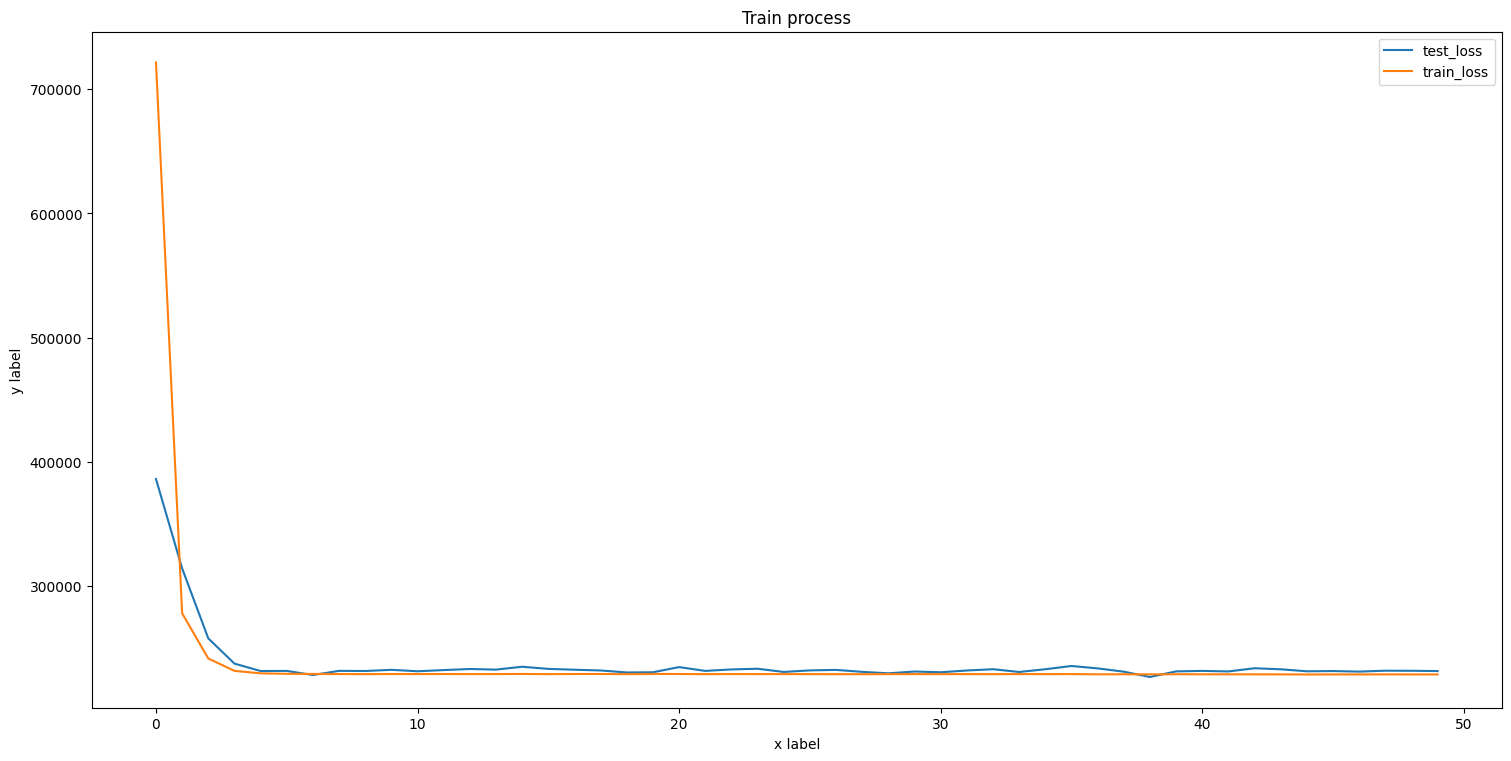

In [24]:
plot_hist_loss(hist_keep)
print(min(hist_keep.test_hist_loss))

## Inference test

In [25]:
class Inference:
    def __init__ (  self,
                    test_dataloader,
                    device,
                    criteria):
        
        self.test_dataloader=test_dataloader
        self.device=device
        self.criteria=criteria

        self.answers = np.empty((3,0), np.half)

    def __join_arrays(self,time_index,target,out):
        time_index=time_index.reshape(1,-1)
        target=target.reshape(1,-1)
        out=out.reshape(1,-1)
        tmp_concat=np.concatenate((time_index,target,out),axis=0)
        # self.answers=np.concatenate((self.answers,tmp_concat),axis=1)
        self.answers=np.append(self.answers, tmp_concat, axis=1)

        
    def run(self, model):
        model.eval()
        self.loss_hist = Metric_hist()
        
        with torch.no_grad():
            for data, target, time_index in self.test_dataloader:
                data_device, target_device = data.to(device), target.to(device)

                # Forward
                out = model(data_device)

                loss=self.criteria(out,target_device)
                self.loss_hist.add_value(float(loss),len(target))

                time_index=time_index.numpy()
                target=target.numpy()
                out=out.detach().cpu().numpy()
                self.__join_arrays(time_index,target,out)


                # self.answers = np.append(self.answers, np.array([[time_index,target,out]]), axis=0)

        total_loss  = self.loss_hist.get_metric
        print(f"\nRESULTS: loss: {total_loss}")
        
        return total_loss

In [26]:
path_save="./weights/best_linear_regr_test.pth"
# path_save="./weights/best_linear_regr_train.pth"


model.load_state_dict(torch.load(path_save))

obj_inference = Inference(test_dataloader,device,criteria)
obj_inference.run(model)
out_predict = obj_inference.answers[-1,:]


RESULTS: loss: 226652.2873


# PLOT Graph

In [27]:
plot_ts_pred(y_test,out_predict)

## Metrisc

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

dict_error = dict()

def error_metrics(y_pred, y_truth, model_name = None, test = True):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [29]:
error_metrics(out_predict, y_test, model_name = 'NN with relu', test = False)


Error metrics for model NN with relu
RMSE or Root mean squared error: 463.19
Variance score: 0.12
Mean Absolute Error: 361.74
Mean Absolute Percentage Error: 15.43 %


In [ ]:
dict_error

In [ ]:
pred=torch.tensor(lm.predict(X_test))

In [ ]:
target=torch.tensor(np.array(y_test))

In [ ]:
criteria = nn.MSELoss()
loss=criteria(pred,target)
loss

In [ ]:
X_train.shape

In [30]:
## Line regression

from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression()

In [31]:
X_train

,HourlyDryBulbTemperature,cum_AC_kW,year_2015,year_2016,year_2017,year_2018,month_2,month_3,month_4,month_5,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,season_winter,non_working_working
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,-1.998981,-1.474575,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 01:00:00,-1.931576,-1.474575,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 02:00:00,-1.891133,-1.474575,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 03:00:00,-2.133791,-1.474575,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-01 04:00:00,-2.295562,-1.474575,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01 21:00:00,-0.785692,1.753704,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
2018-04-01 22:00:00,-0.751990,1.753704,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
2018-04-01 23:00:00,-0.785692,1.753704,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False


In [32]:
plot_ts_pred(y_test, lm.predict(X_test), model_name='Simple linear regression with scaling', 
             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [33]:
lm.coef_[12]

216724003310979.7

In [34]:
list(model.named_parameters())

[('fc1.weight',
  Parameter containing:
  tensor([[ 1.7208e+01, -9.9860e+01,  6.1973e+01,  1.5505e+02,  2.3189e+02,
            3.0805e+02,  1.1305e+00,  4.2849e+00, -1.0539e+00,  1.2553e+01,
            3.0327e+02,  3.2381e+02,  3.3653e+02,  3.3872e+02,  3.2879e+02,
            5.2949e+01,  6.7054e+01,  3.3405e+00,  4.3224e+00,  1.8478e-01,
            4.8330e+00,  9.3116e+00,  2.1638e+01,  2.4116e+01,  3.0670e+01,
            2.8558e+01,  2.6697e+01,  3.2314e+01,  3.6122e+01,  3.7593e+01,
            4.0016e+01,  3.9276e+01,  4.8724e+01,  5.7078e+01,  6.2254e+01,
            6.4997e+01,  6.2172e+01,  5.0734e+01,  3.5629e+01,  2.3051e+01,
            2.7402e+02,  1.6989e+01]], requires_grad=True)),
 ('fc1.bias',
  Parameter containing:
  tensor([1905.0148], requires_grad=True)),
 ('act_snake.a',
  Parameter containing:
  tensor([954.7298], requires_grad=True))]

In [35]:
error_metrics(lm.predict(X_test), y_test, model_name = 'Sk_learn', test = False)


Error metrics for model Sk_learn
RMSE or Root mean squared error: 254.93
Variance score: 0.73
Mean Absolute Error: 195.01
Mean Absolute Percentage Error: 8.38 %
